## Solving the multi-arm bandit

Let’s say you’re at a casino, and in front of you are 10 slot machines with a flashy
sign that says “Play for free! Max payout is $10!” Wow, not bad! Intrigued, you ask one
of the employees what’s going on, because it seems too good to be true, and she says,
“It’s really true, play as much as you want, it’s free. Each slot machine is guaranteed to
give you a reward between $0 and $10. Oh, by the way, keep this to yourself, but those
10 slot machines each have a different average payout, so try to figure out which one
gives the most rewards on average, and you’ll be making tons of cash!”

### Greedy epsilon Strategy

- We do a exploitation (choose best machine) and exploration (choose random machine) of slot machines
- choose a parameter (epsilon) that can control between the two approaches.
- Get average of each slot machine output. We take a fixed random number (probability) for each machine and add one dollar each time a random number comes greater than the probability. 
- For each arm (action): set up a for loop going to 10 (max reward), and at each step it will add 1 to the reward if a
random float is less than the arm’s probability. RUnning this for many iterations will give the value (prob*max_reward).

In [3]:
import numpy as np

# Number of slot machines/arms
N = 10

# probability for each arm 
prob_a = np.random.rand(N)


# get reward for an arm with given probability
def get_reward(prob, max_reward=10):
    reward = 0
    for _ in range(max_reward):
        if np.random.random() < prob:
            reward += 1
    return reward



# function to update the reward for an action (a) of chosing an arm at each iteration
def update_reward(record,a,reward):
    
    # update the mean and count of the arm a
    new_mean = (record[a][1]*record[a][0]+reward)/(record[a][0]+1)
    record[a][0] += 1
    record[a][1] = new_mean
    
    return record


# function to choose an arm to pull at each iteration
def choose_arm(record,epsilon):
    # choose a random number between 0 and 1
    rand = np.random.rand()
    
    # if the random number is less than epsilon, choose a random arm
    if rand < epsilon:
        return np.random.randint(N)
    
    # else, choose the arm with the highest mean reward
    else:
        return np.argmax(record[:,1],axis=0)
    

(0.0, 10.0)

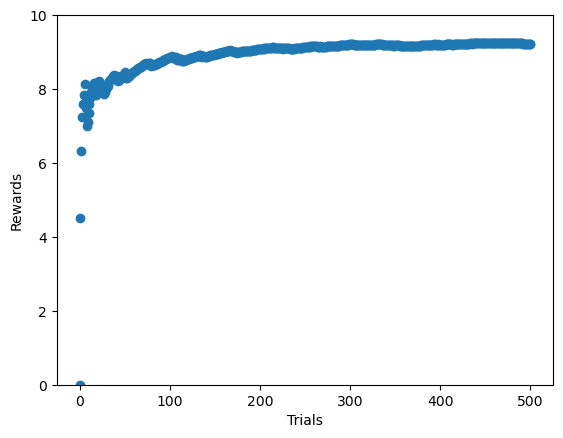

In [4]:
import matplotlib.pyplot as plt

# number of iterations
iterations = 500

# epsilon for exploration
epsilon = 0.2

# record array with shape (N,2) 
# col1: the number of times each arm has been pulled 
# col2: the total reward for each arm
record = np.zeros((N,2))


fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Trials')
ax.set_ylabel(r'Rewards')

rewards=[0]
# loop over iterations
for i in range(iterations):
    # choose an arm to pull
    a = choose_arm(record,epsilon)
    # get the reward for the chosen arm
    reward_i = get_reward(prob_a[a])
    # update the reward for the chosen arm
    record = update_reward(record,a,reward_i)
    mean_reward = ((i+1) * rewards[-1] + reward_i)/(i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)
ax.set_ylim(0,10)

### Softmax selection

A newly minted doctor specializes in treating
patients with heart attacks. She has 10 treatment options, of which she can choose
only 1 to treat each patient she sees. For some reason, all she knows is that these 10
treatments have different efficacies and risk profiles for treating heart attacks—she
doesn’t know which one is the best yet. We could use the n-armed bandit algorithm
from the previous solution, but we might want to reconsider our ε-greedy policy of
randomly choosing a treatment once in a while. In this new problem, randomly choosing
a treatment could result in patient death, not just losing some money. We really
want to make sure we don’t choose the worst treatment, but we still want some ability
to explore our options to find the best one.

In [6]:
def softmax(av, tau=1.12):
    """
    Function for softmax
    Input:
        av: action value vector
        tau: temperature
    Output:
        softm: Probability vector for each action
    """
    softm = np.exp(av / tau) / np.sum( np.exp(av / tau) )
    return softm


The np.random.choice function in NumPy is used to generate a random sample from a given 1-D array. It allows you to randomly select elements, either with or without replacement, from the specified array or sequence

(0.0, 10.0)

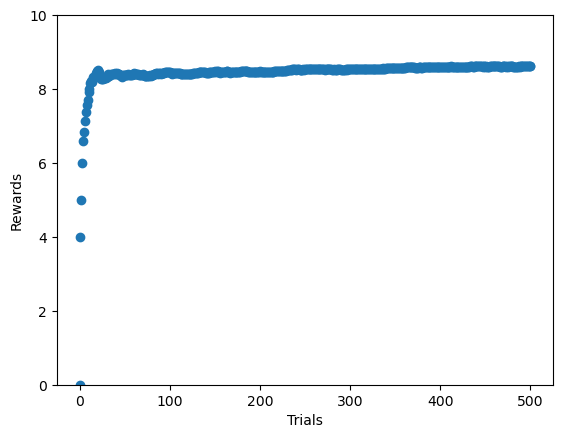

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# number of iterations
iterations = 500

# temperature for softmax
tau = 0.2

# record array with shape (N,2) 
# col1: the number of times each arm has been pulled 
# col2: the total reward for each arm
record = np.random.rand(N,2)


fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Trials')
ax.set_ylabel(r'Rewards')

rewards=[0]
# loop over iterations
for i in range(iterations):
    # choose an arm to pull
    a = np.random.choice(np.arange(N),p=softmax(record[:,1],tau))
    # get the reward for the chosen arm
    reward_i = get_reward(prob_a[a])
    # update the reward for the chosen arm
    record = update_reward(record,a,reward_i)
    mean_reward = ((i+1) * rewards[-1] + reward_i)/(i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)
ax.set_ylim(0,10)

for softmax the rewards converge faster

## Contextual bandit

Let’s say we manage 10 e-commerce websites, each focusing on selling a different
broad category of retail items such as computers, shoes, jewelry, etc. We want to
increase sales by referring customers who shop on one of our sites to another site
that they might be interested in. When a customer checks out on a particular site in
our network, we will display an advertisement to one of our other sites in hopes
they’ll go there and buy something else. Alternatively, we could place an ad for
another product on the same site. Our problem is that we don’t know which sites we
should refer users to. We could try placing random ads, but we suspect a more targeted
approach is possible.


At each play of the game
(each time a customer checks out on a particular website) we have n = 10 possible
actions we can take, corresponding to the 10 different types of advertisements we
could place. The twist is that the best ad to place may depend on which site in the network
the current customer is on. For example, a customer checking out on our jewelry
site may be more in the mood to buy a new pair of shoes to go with their new
diamond necklace than they would be to buy a new laptop. Thus our problem is to figure
out how a particular site relates to a particular advertisement.

In [7]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
    
    # initial distribution of states space probabilities
    def init_distribution(self, arms):
        # assuming states are equal to arms so matrix is armsxarms
        self.bandit_matrix = np.random.rand(arms, arms)

    # setting rewards for a particlar state
    def reward(self, prob):
        reward = 0
        for _ in range(self.arms):
            if np.random.random() < prob:
                reward += 1
        return reward
    
    # getting the current state
    def get_state(self):
        return self.state
    
    # updating the state
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
    
    # get reward for a particular arm
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
    
    # choose an arm which means putting ads on site
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward
    

In [8]:
import numpy as np
import torch

# number of arms
arms = 10
# batch size
N= 1
# input dimension
D_in= arms
# hidden dimension
H= 200
# output dimension
D_out=arms

# model with two layers
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

# loss function
loss_fn = torch.nn.MSELoss()

# get environment instance
env = ContextBandit(arms)

# one hot encoding
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec


In [ ]:
# training function
def train(env, epochs=5000, learning_rate=1e-2):
    # initial state will be a random integer denoting a state but 
    cur_state = torch.Tensor(one_hot(arms,env.get_state()))

    # optimizer function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # reward array
    rewards = []


    # main loop of training
    for i in range(epochs):
        # get prediction for current state
        y_pred = model(cur_state)
        # pass through softmax function to get probabilities
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0)
        # normalize
        av_softmax /= av_softmax.sum()
        # choose an arm
        choice = np.random.choice(arms, p=av_softmax)
        # get reward for choosing an arm
        cur_reward = env.choose_arm(choice)
        # one hot encoding for reward for setting reward only for that arm
        one_hot_reward = y_pred.data.numpy().copy()
        one_hot_reward[choice] = cur_reward
        reward = torch.Tensor(one_hot_reward)

        # append reward
        rewards.append(cur_reward)
        # get loss
        loss = loss_fn(y_pred, reward)
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # set current state to new state
        cur_state = torch.Tensor(one_hot(arms,env.get_state()))

    # at the end return rewards    
    return np.array(rewards)



(5000,)


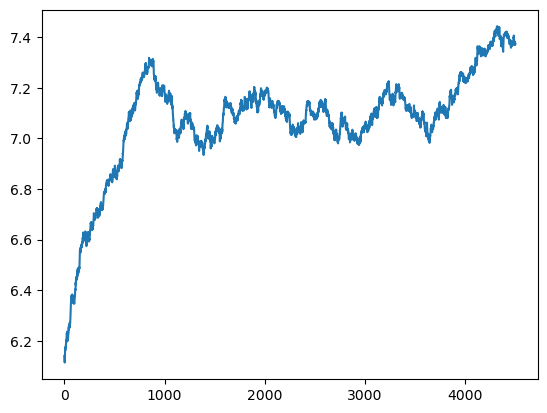

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y


rewards2 = train(env)
print(rewards2.shape)
plt.plot(running_mean(rewards2,N=500))

Even with this simple two layer agent, rewards increase consistently.

## Q-Learning

Sure! Here's a concise explanation of **Q-Learning**:

---

### ✅ **Q-Learning in Short**

**Q-Learning** is a **model-free reinforcement learning algorithm** that learns the **optimal action-value function** $Q(s, a)$, which tells an agent the expected future rewards for taking action $a$ in state $s$, and then following the best policy thereafter.

---

### 🔁 **Key Steps:**

1. **Initialize** a Q-table (or a neural network in Deep Q-Learning) with arbitrary values. With 

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$


2. **Observe** the current state $s$.

3. **Choose an action** $a$ using a policy (e.g., ε-greedy: mostly choose the best action, sometimes explore).

4. **Take the action**, receive **reward** $r$, and observe the **next state** $s'$.

5. **Update the Q-value** using the **Bellman equation**:

   $$
   Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
   $$

   * $\alpha$: learning rate
   * $\gamma$: discount factor (future reward importance)

6. **Repeat** for many episodes.

---

### 🧠 Goal:

Learn the **optimal policy**:

$$
\pi^*(s) = \arg\max_a Q(s, a)
$$

---

Let me know if you'd like a visual or simple Python code example!




---

### ❓ **How can a Q-network predict the future if it hasn't seen it yet?**

It **doesn't literally know the future** — instead, it **learns an estimate** of the *expected cumulative future reward* **based on past experience**. Think of it like this:

> 🧠 The Q-network is guessing (predicting) how good an action is, based on similar situations it has seen before during training.

---

### 🔁 The trick: Bootstrapping

Q-learning uses a process called **bootstrapping**. Here's how it works:

Let’s say the agent sees this experience:

$$
(S_t, A_t, R_{t+1}, S_{t+1})
$$

The Q-network makes a prediction:

$$
Q(S_t, A_t)
$$

It then computes the **target value** using:

$$
\text{Target} = R_{t+1} + \gamma \cdot \max_{a'} Q(S_{t+1}, a')
$$

That second term, $\max_{a'} Q(S_{t+1}, a')$, is the Q-network’s own estimate of the best possible future reward from the new state $S_{t+1}$. So it's like the agent is **learning from its own predictions** of the future, updating and correcting itself over time.

---

### 🧪 Example

Imagine you're in a gridworld at position A. Your Q-network says:

* Go right: Q-value = 3.0
* Go down: Q-value = 4.5

You go **down**, get a reward of +1, and land in position B.

The Q-network says:

* From B, the best next Q-value is 6.0

So you update your estimate:

$$
Q(\text{A}, \text{down}) \leftarrow 1 + \gamma \cdot 6.0
$$

If $\gamma = 0.9$, this becomes:

$$
Q(\text{A}, \text{down}) \leftarrow 1 + 0.9 \cdot 6 = 6.4
$$

So the agent updates its network to try to predict 6.4 next time it's in position A and thinking of going down.

---

### 🧠 TL;DR

* The Q-network **doesn't know the future**.
* It **predicts** the expected total reward *based on what it's learned from past experiences*.
* It updates its guesses using the **reward it actually gets** and its **own predictions** for the next state (bootstrapping).
* Over time, with enough experience, it gets better at estimating long-term outcomes.



### GridWorld Game

In [1]:
from utils.Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [2]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

**Symbol meanings (likely guesses):**

* **'P'** — Player or agent's current position.
* **'+'** — Goal state or a high-reward terminal state (often positive reward).
* **'-'** — Negative terminal state (like a pit or penalty state).
* **'W'** — Wall or obstacle (impassable cell).
* **' '** (space) — Empty/regular cell that can be traversed.

### Interpretation of the grid:

* The player (`P`) starts at position `(0, 3)`.
* The goal (`+`) is at `(0, 0)`.
* A negative terminal (`-`) is at `(0, 1)`.
* There's a wall (`W`) at `(1, 1)`.
* The rest are empty navigable cells.

This kind of setup is typical in grid-based MDP environments (e.g., Sutton & Barto’s examples), where an agent must learn an optimal policy to reach the goal while avoiding penalties.


In [7]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [8]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [9]:
game.board.render_np().shape

(4, 4, 4)

In [7]:
import numpy as np
import torch
from utils.Gridworld import Gridworld
import random
from matplotlib import pylab as plt

# 4x4x4 input layer
l1 = 64
# 2 hidden layers
l2 = 150
l3 = 100
# output layer given 4 actions 'left', 'right', 'up', 'down'
l4 = 4

# initialize model
model = torch.nn.Sequential(
torch.nn.Linear(l1, l2),
torch.nn.ReLU(),
torch.nn.Linear(l2, l3),
torch.nn.ReLU(),
torch.nn.Linear(l3,l4)
)

# loss function
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# hyperparameters
# discount factor
gamma = 0.9
# epsilon for exploration
epsilon = 1.0

In [8]:
# set of actions mapped to strings
action_set = {
                0: 'u',
                1: 'd',
                2: 'l',
                3: 'r',
            }

In [14]:
import tqdm 
# Number of epochs
epochs = 1000

# empty list to store losses
losses = []
for i in tqdm.tqdm(range(epochs)): 
    # initialize game
    game = Gridworld(size=4, mode='static') 
    # get initial state and add random noise
    # Why did we add noise to the game state? It helps prevent “dead neurons,”
    # which can happen with the use of rectified linear units (ReLU) as our
    # activation function. Basically, because most of the elements in our game
    # state array are 0s, they won’t play nice with ReLU, which is technically nondifferentiable
    # at 0. Hence, we add a tiny bit of noise so that none of the values
    # in the state array are exactly 0. This might also help with overfitting,

    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 
    # convert to tensor
    state = torch.from_numpy(state_).float() 
    # initialize status 1 if game is still being played
    status = 1 
    # play the game
    while(status == 1): 
        # get Q values of current state
        qval = model(state) 
        # convert to numpy
        qval_ = qval.data.numpy()

        # Greedy Epsilon strategy to decide next action
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        # get key for action
        action = action_set[action_]

        # make move 
        game.makeMove(action) 

        # get next state
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() 
        # get reward
        # every nonwinning
        # move receives a –1 reward. The winning move (reaching the goal) receives a +10
        # reward, and there’s a –10 reward for the losing move (landing on the pit).
        reward = game.reward()

        # save memory by not saving the gradient for new Q
        with torch.no_grad():
            newQ = model(state2.reshape(1,64))
        # get maximum Q for target Q value
        maxQ = torch.max(newQ) 
        # if nonwinning move
        if reward == -1: 
            Y = reward + (gamma * maxQ)
        # if ended up in pit or reached goal
        else: 
            Y = reward
        
        # detach the tensor from the computation graph
        Y = torch.Tensor([Y]).detach()

        # This applies the squeeze() method to the tensor qval, 
        # which removes any singleton dimensions (i.e., dimensions of size 1) 
        # from the tensor. 
        # This is often used to remove unnecessary dimensions from a tensor.
        X = qval.squeeze()[action_] 

        # get loss from target and prediction
        loss = loss_fn(X, Y) 
        #print(i, loss.item())
        # clear_output(wait=True)

        # make the gradients zero
        optimizer.zero_grad()
        # backpropagate loss
        loss.backward()
        # append loss
        losses.append(loss.item())
        # readjust the weights
        optimizer.step()

        # set new state
        state = state2
        # check if the game is to be stopped
        if reward != -1: 
            status = 0
    # implement adaptive epsilon greedy strategy
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/ankit/miniconda3/envs/ML/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [01:26<00:00, 11.59it/s]


Text(0, 0.5, 'Loss')

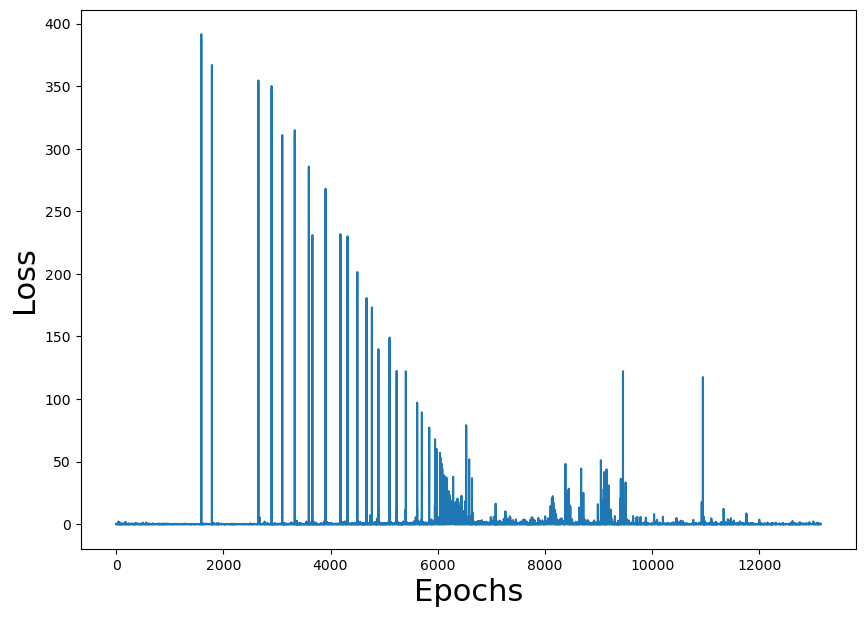

In [15]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [5]:
# Function for the testing
def test_model(model, mode='static', display=True):
    i = 0
    # initialize game
    test_game = Gridworld(mode=mode)
    # get initial state and add random noise
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): 
        # get Q values of current state
        qval = model(state)
        qval_ = qval.data.numpy()
        # get action for the maximum Q
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        
        # make move
        test_game.makeMove(action)
        # get next state
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        # convert to tensor
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        
        # get reward
        reward = test_game.reward()
        # check if the game is to be stopped
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [29]:
test_model(model, mode='static', display=True)

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [30]:
test_model(model, mode='random', display=True)

Initial State:
[[' ' ' ' 'P' ' ']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'W' '+' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 ['-' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'W' '+' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' 'W' '+' ' ']]
Move #: 2; Taking action: l
[[' ' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' 'W' '+' ' ']]
Move #: 3; Taking action: l
[[' ' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' 'W' '+' ' ']]
Move #: 4; Taking action: u
[[' ' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'W' '+' ' ']]
Game LOST. Reward: -10


False

It seems like the model just memorized the particular board it was trained on and didn’t generalize at all.

### catastrophic forgetting

The main problem we encountered in the previous section when we tried to train our
model on random mode has a name: catastrophic forgetting. It’s actually a very important
issue associated with gradient descent-based training methods in online training.
Online training is what we’ve been doing: we backpropagate after each move as we
play the game.

Imagine that our algorithm is training on (learning Q values for) game 1 of figure
3.12. The player is placed between the pit and the goal such that the goal is on the
right and the pit is on the left. Using an epsilon-greedy strategy, the player takes a random
move and by chance steps to the right and hits the goal. Great! The algorithm
will try to learn that this state-action pair is associated with a high value by updating its
weights in such a way that the output will more closely match the target value (i.e. via
backpropagation).

Now game 2 is initialized and the player is again between the goal and pit, but this
time the goal is on the left and the pit is on the right. Perhaps to our naive algorithm, the
state seems very similar to the last game. Since last time moving right gave a nice positive
reward, the player chooses to make one step to the right again, but this time it ends up
in the pit and gets –1 reward. The player is thinking, “What is going on? I thought going
to the right was the best decision based on my previous experience.” It may do backpropagation
again to update its state-action value, but because this state-action is very
similar to the last learned state-action, it may override its previously learned weights.


This is the essence of catastrophic forgetting. There’s a push-pull between very similar
state-actions (but with divergent targets) that results in this inability to properly learn
anything.

### Experience Replay

- In state $s$, take action $a$, and observe the new state $s_{t+1}$ and reward $r_{t+1}$.
- Store this as a tuple $(s, a, s_{t+1}, r_{t+1})$ in a list.
- Continue to store each experience in this list until you have filled the list to a
specific length (this is up to you to define).
- Once the experience replay memory is filled, randomly select a subset (again,
you need to define the subset size).
- Iterate through this subset and calculate value updates for each subset; store
these in a target array (such as $Y$) and store the state, $s$, of each memory in $X$.
- Use $X$ and $Y$ as a mini-batch for batch training. For subsequent epochs where the
array is full, just overwrite old values in your experience replay memory array.

In [2]:
import numpy as np
import torch
from utils.Gridworld import Gridworld
import random
from matplotlib import pylab as plt
from collections import deque
import tqdm

# 4x4x4 input layer
l1 = 64
# 2 hidden layers
l2 = 150
l3 = 100
# output layer given 4 actions 'left', 'right', 'up', 'down'
l4 = 4

# initialize model
model = torch.nn.Sequential(
torch.nn.Linear(l1, l2),
torch.nn.ReLU(),
torch.nn.Linear(l2, l3),
torch.nn.ReLU(),
torch.nn.Linear(l3,l4)
)

# loss function
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# hyperparameters
# discount factor
gamma = 0.9
# epsilon for exploration
epsilon = 1.0
# set of actions mapped to strings
action_set = {
                0: 'u',
                1: 'd',
                2: 'l',
                3: 'r',
            }


# number of epochs
epochs = 5000

losses = []

# setting memory for experience replay
mem_size = 1000 
# setting batch size
batch_size = 200 
# setting memory as deque list
# A deque is a data structure that allows you to add or remove elements from both ends (i.e., the beginning and the end).
# maxlen=mem_size sets the maximum length of the deque to mem_size. 
# This means that when the deque reaches this length, adding a new element will automatically remove 
# the oldest element to make room for the new one.
replay = deque(maxlen=mem_size) 

# max moves before the game ends
max_moves = 50 
h = 0
for i in tqdm.tqdm(range(epochs)):
    # initialize game with random board
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    # counter for the number of moves
    mov = 0
    while(status == 1): 
        mov += 1
        # get Q values of current state
        qval = model(state1) 
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False

        # create memory
        exp =  (state1, action_, reward, state2, done) 
        # append memory
        replay.append(exp) 
        # update state
        state1 = state2
        
        # check if the number of moves is greater than batch size
        if len(replay) > batch_size: 
            # sample batch size randomly from replay
            minibatch = random.sample(replay, batch_size) 

            # separate states, actions, rewards, next states and dones
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) 
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            # get Q values from randomly sampled batch
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model(state2_batch) 
            
            # Compute Targets using Bellman Equation
            # If episode is done, future rewards are ignored using (1 - done_batch)
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) 
            # Select Q-values of taken actions from Q1
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            # print(i, loss.item())
            # clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: 
            status = 0
            mov = 0
losses = np.array(losses)

100%|██████████| 5000/5000 [25:44<00:00,  3.24it/s]  



Each episode (game) runs:

```python
while status == 1:
    mov += 1
    ...
    replay.append(exp)
```

We **append one transition per move**, so:

* After each **episode**, you add up to **50 experiences** to `replay`.
* So, the replay buffer starts small and fills up gradually.
* The `if len(replay) > batch_size:` condition is only satisfied after **at least 201 experiences**.

This means:

* **No training** happens in the **first few episodes**.
* Training starts around episode **5 to 6**, since 50 moves × 5 episodes ≈ 250 transitions → buffer large enough.

---

### 📌 What does this mean practically?

* For episodes **1–5**, the agent plays but doesn’t learn (only fills replay buffer).
* From episode **6 onward**, training starts using **random minibatches of size 200**.
* The buffer **never exceeds 1000 items** due to `maxlen=1000`.


Text(0, 0.5, 'Loss')

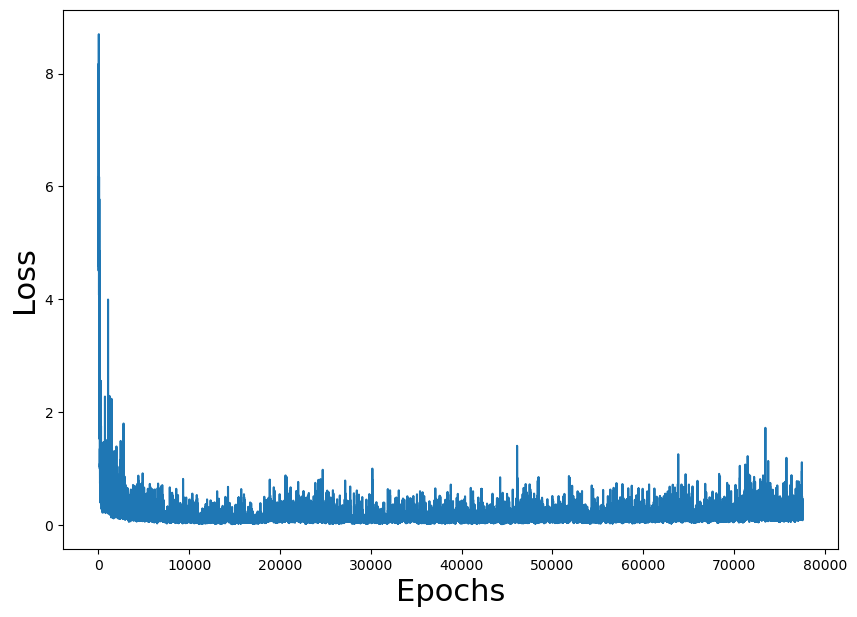

In [3]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [6]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))

Games played: 1000, # of wins: 597
Win percentage: 0.597


 Model is able win 60% of the games.

### Target Network


1. **Initialize Q-network with parameters** `θ_Q`

   > Your main model: `model = QNetwork()`

2. **Initialize target network** with **same weights**: `θ_T = θ_Q`

   > `target_model.load_state_dict(model.state_dict())`
   > This network is *not trained* continuously, only updated periodically.

3. **Use epsilon-greedy strategy** with Q-network to choose action `a`

   > Use the Q-network for action selection:

   ```python
   if random() < epsilon:
       action = random.choice(actions)
   else:
       qvals = model(state)
       action = torch.argmax(qvals)
   ```

4. **Take action**, observe reward `rₜ₊₁` and new state `sₜ₊₁`

   > Standard interaction with the environment

5. **Compute target Q-value** using **target network**:

   ```python
   if done:
       target = reward
   else:
       with torch.no_grad():
           target = reward + gamma * torch.max(target_model(next_state))
   ```

   > This keeps the target stable — the key to DQN’s stability.

6. **Update Q-network** (not target network) by minimizing the loss:

   ```python
   pred = model(state)[action]
   loss = MSELoss(pred, target)
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   ```

7. **Every `C` steps**, update target network: `θ_T ← θ_Q`

   ```python
   if step % C == 0:
       target_model.load_state_dict(model.state_dict())
   ```


